<a href="https://colab.research.google.com/github/Odima-dev/Data-Science-and-Machine-Learning/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Problem 1: Learning / Estimation
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Creating my project folder
!mkdir -p "/content/drive/MyDrive/U-netProject"
project_folder = "/content/drive/MyDrive/U-netProject"

Mounted at /content/drive


In [ ]:
# Cloning the ObjectDetection GitHub Repository
!git clone https://github.com/zhixuhao/unet.git "{project_folder}"

Cloning into '/content/drive/MyDrive/U-netProject'...
remote: Enumerating objects: 394, done.
remote: Total 394 (delta 0), reused 0 (delta 0), pack-reused 394 (from 1)
Receiving objects: 100% (394/394), 44.92 MiB | 19.03 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Updating files: 100% (253/253), done.


In [5]:
cd "{project_folder}"

/content/drive/MyDrive/U-netProject


In [ ]:
# Uploading Competition Data
from google.colab import files
uploaded = files.upload()

Saving competition_data.zip to competition_data.zip


In [ ]:
# Extracting the files
!unzip -q competition_data.zip -d "{project_folder}"

In [ ]:
ls

competition_data/     data.py    main.py       trainUnet.ipynb
competition_data.zip  img/       model.py
data/                 LICENSE    __pycache__/
dataPrepare.ipynb     __MACOSX/  README.md


In [ ]:
# Installing dependencies
!pip install tensorflow keras matplotlib pillow scikit-learn

In [ ]:
# Modernizing Libraries
!sed -i \
    -e 's/from keras/from tensorflow.keras/g' \
    -e 's/Model(input/Model(inputs/g' \
    -e 's/output=/outputs=/g' \
    -e 's/fit_generator/fit/g' \
    -e 's/predict_generator/predict/g' \
    -e "s/'unet_membrane.hdf5'/'unet_membrane.keras'/g" \
    -e 's/lr=/learning_rate=/g' \
    "{project_folder}/main.py"

!sed -i \
    -e 's/from keras/from tensorflow.keras/g' \
    -e '/def adjustData/,/^$/c\def adjustData(img, mask, flag_multi_class, num_class):\n    # Normalize image\n    img = img / 255.0\n    # Handle mask bit depth\n    if mask.dtype == np.uint16:\n        mask = (mask / 65535.0).astype(np.float32)\n    else:\n        mask = (mask / 255.0).astype(np.float32)\n    if flag_multi_class:\n        mask = mask[:, :, :, 0] if len(mask.shape) == 4 else mask[:, :, 0]\n        new_mask = np.zeros(mask.shape + (num_class,))\n        for i in range(num_class):\n            new_mask[mask == i, i] = 1\n        mask = np.reshape(new_mask, (new_mask.shape[0], new_mask.shape[1] * new_mask.shape[2], new_mask.shape[3]))\n    else:\n        mask[mask > 0.5] = 1\n        mask[mask <= 0.5] = 0\n    return img, mask\n' \
    "{project_folder}/data.py"


In [ ]:
# Creating a dummy  subfolder for both images and masks
!mkdir -p competition_data/train/images/dummy_class \
         competition_data/train/masks/dummy_class && \
mv competition_data/train/images/*.* competition_data/train/images/dummy_class/ && \
mv competition_data/train/masks/*.* competition_data/train/masks/dummy_class/


In [ ]:
# Confirmation of program operation
!python main.py

2025-07-29 02:27:05.925610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753756026.005731   29215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753756026.031415   29215 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-29 02:27:06.142843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-29 02:27:14.437051: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

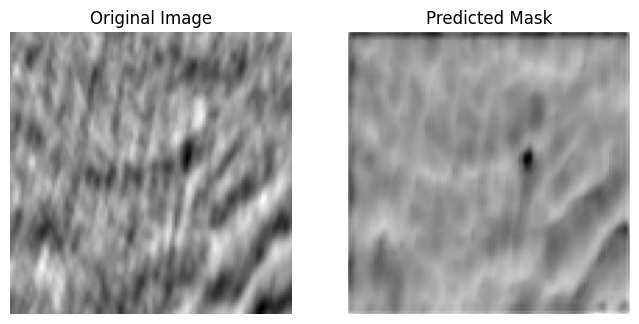

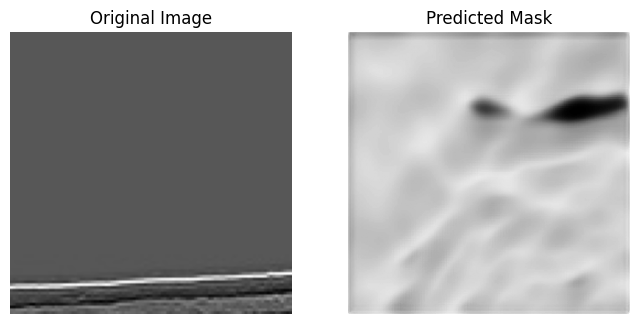

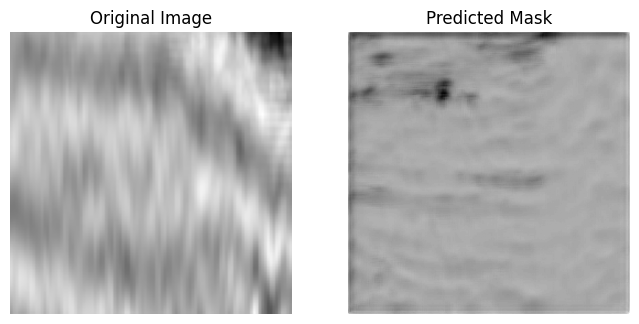

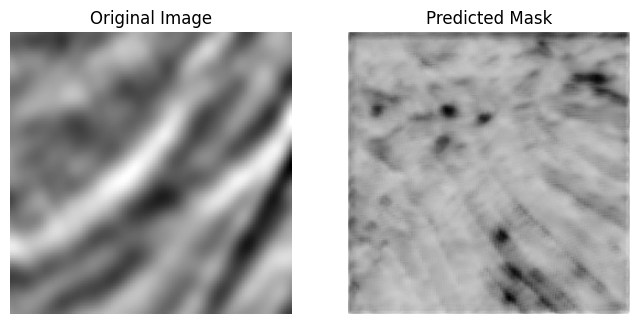

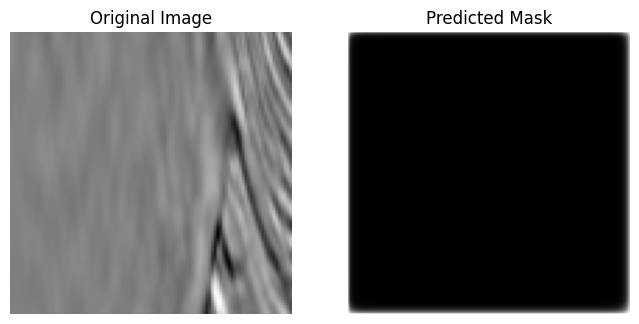

In [14]:
#  visualizing original images alongside their predicted masks
import matplotlib.pyplot as plt
import os
import skimage.io as io

# Paths
test_path = "competition_data/test/images"
pred_files = sorted([f for f in os.listdir(test_path) if f.endswith("_predict.png")])
orig_files = sorted([f for f in os.listdir(test_path) if not f.endswith("_predict.png")])

# Showing first 5 samples
for i in range(5):
    orig = io.imread(os.path.join(test_path, orig_files[i]))
    pred = io.imread(os.path.join(test_path, pred_files[i]))

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(orig, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(pred, cmap='gray')
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")

    plt.show()


In [ ]:
#Problem 2: Code reading

# 1. The key part of U-Net in this implementation is upsampling and skip connections
# Found in model.py, Lines 33-34, as shown below

up6 = Conv2D(512, 2, activation='relu', padding='same',
             kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)

"""
  UpSampling2D doubles the map spatial resolution of feature maps.

  The upsampled feature maps then go through Conv2D(512, 2) for processing.

  concatenate([drop4, up6], axis=3) combines the encoder (drop4) features with the upsampled decoder features (up6)- a skip connection.

  The same thing is repeated with more layers (merge7, merge8, merge9).
"""

# 2. Import of the library used in my implementation is as follows
import glob
import cv2
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

"""
  These imports provide image handling (cv2, skimage), deep learning building blocks (keras), and plotting (matplotlib).
"""

# 3. Data Loading, as displayed within the main flow, was implemented as follows
image_path_list = glob.glob("competition_data/train/images/*")
X_train = []
y_train = []
for image_path in image_path_list[:100]:
    image = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255, (256, 256))
    X_train.append(image)
    mask = cv2.resize(
        cv2.imread(image_path.replace("images", "masks"), cv2.IMREAD_GRAYSCALE) / 255,
        (256, 256),
    )
    y_train.append(mask)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

"""
  Line 1: List of image paths
  Lines 2 to 3: Define list for data storage
  Line 4: Loop over the first 100 image paths
  Line 5: Resizes grayscale images
  Line 6: Append the processed image to the training image list
  Lines 7 - 8: Reads the respective mask by substituting images with masks in path, normalises it, resizes to 256x256 and adds to mask list.
  Line 9 to 10: numpy arrayization
  Lines 11 to 12: Adds a channel dimension
"""

# 4. U-Net Model Definition

"""
  In this implementation, a unet function is defined.

  Inside this function, a full U-Net model is constructed and compiled, and then returned as the function’s output.
"""

def unet(pretrained_weights=None, input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    ...
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
             UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    ...
    conv10 = Conv2D(1, 1, activation='sigmoid', name="output")(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    if pretrained_weights:
        model.load_weights(pretrained_weights)
    return model

"""
  Encoder path: Conv2D - MaxPooling (reduces spatial size, extracts features).

  Bottleneck: Deep layers (1024 filters) with dropout.

  Decoder path: UpSampling - Concatenation - Convolution (restores resolution).

  Output: Single-channel sigmoid (for binary segmentation).

  Compile: Uses Adam optimizer and binary cross-entropy.
"""

# 5 Learning and Checkpointing, located in main.py

model_checkpoint = ModelCheckpoint('unet_membrane.keras',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)
model.fit(train_gen, steps_per_epoch=300, epochs=1,
          callbacks=[model_checkpoint])

"""
  ModelCheckpoint: Saves best model automatically.

  Training: Uses data generator (train_gen) with augmentation for one epoch.
"""

# 6. Estimation and Visualization

test_gen = testGenerator('competition_data/test/images')
results = model.predict(test_gen, steps=30, verbose=1)
saveResult('competition_data/test/images', results)

"""
  Once training is complete:

  1. testGenerator: Loads test images.

  2. predict: Runs segmentation inference on 30 images.

  3. saveResult: Saves predicted masks as images (*_predict.png).
"""